# Dataset Augmentation Experiments

This notebook visualizes the dataset augmentation methods we use in other notebooks, such as flips, rotations, reflection paddings and color jitters. The main purpose of this notebook is to experiment with different parameters.

In [1]:
import os
import random
from glob import glob
from PIL import Image

import torchvision.transforms as T
import torchvision.transforms.functional as TF

from src.utils import *
from src.dataset_augmentation import *

Let us first load a few test images which look very different from each other.

In [2]:
image_fns = sorted(glob(os.path.join("training", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training", "groundtruth", "*.png")))

images = [Image.open(image_fns[0]), Image.open(image_fns[5]), Image.open(image_fns[14])]
masks = [Image.open(mask_fns[0]), Image.open(mask_fns[5]), Image.open(mask_fns[14])]

In the following, we generate new samples by applying random rotations and flips. To deal with the missing values after rotating an image, we first increase the image with reflection padding. After the rotation, we simply take a center crop to obtain the original image size.

We don't rotate images by any random degree in [0, 360] because if you e.g. rotate an image by 45 degrees, a lot of information is missing in the corners and the result often looks weird when the missing parts are replaced with reflection padding. To mitigate this issue, we first randomly rotate the image by 0/90/180/270 degrees and then apply a second random rotation with a degree within a small range, e.g. [-15, 15].

### Visualization of too much missing information after rotating

Original image size:	(400, 400)
Padded image size:	(560, 560)
Rotated image size:	(560, 560)
Final image size:	(400, 400)


Bad: When rotating by 45°, too much information is missing in the corners for a realisitc looking result.


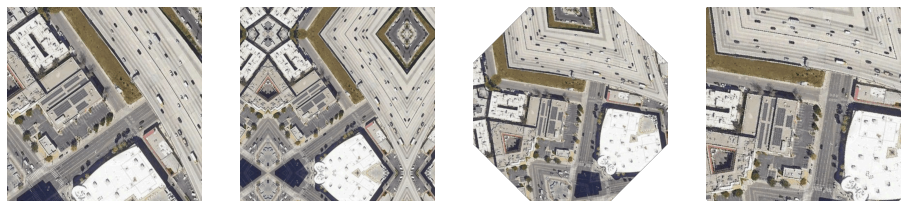



Better: When rotating by 15° the result looks much more convincing (not perfect though).


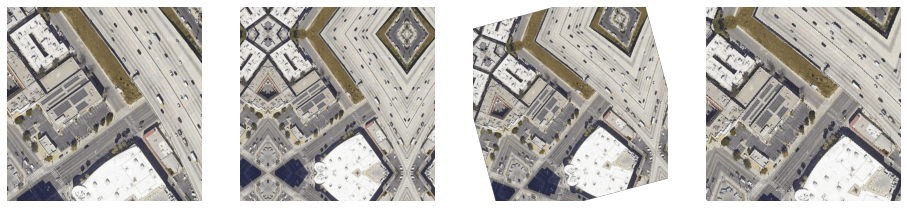

In [3]:
original_img = images[0]
print(f"Original image size:\t{original_img.size}")

padded_img = TF.pad(img=original_img, 
                    padding=[original_img.size[0] // 5, original_img.size[1] // 5], 
                    padding_mode="reflect")
print(f"Padded image size:\t{padded_img.size}")

rotated_img_bad = TF.rotate(padded_img, 45)
rotated_img_good = TF.rotate(padded_img, 15)
print(f"Rotated image size:\t{rotated_img_bad.size}")

final_img_bad = TF.center_crop(rotated_img_bad, original_img.size)
final_img_good = TF.center_crop(rotated_img_good, original_img.size)
print(f"Final image size:\t{final_img_bad.size}")

print("\n\nBad: When rotating by 45°, too much information is missing in the corners for a realisitc looking result.")
plot_images([original_img, padded_img, rotated_img_bad, final_img_bad])

print("\n\nBetter: When rotating by 15° the result looks much more convincing (not perfect though).")
plot_images([original_img, padded_img, rotated_img_good, final_img_good])

### Rotation and Flips
Let us visualize some newly generated samples using our test images.

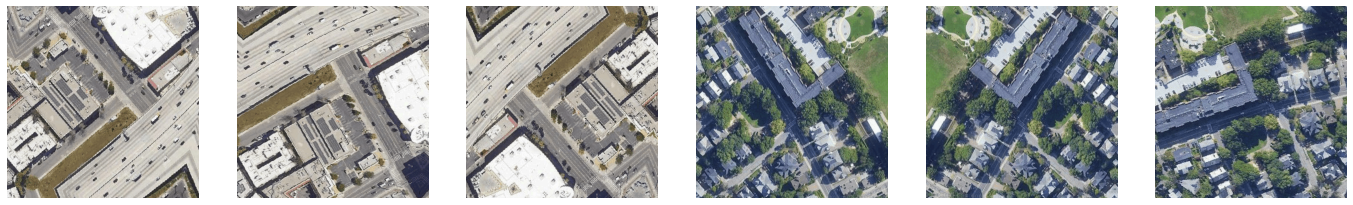

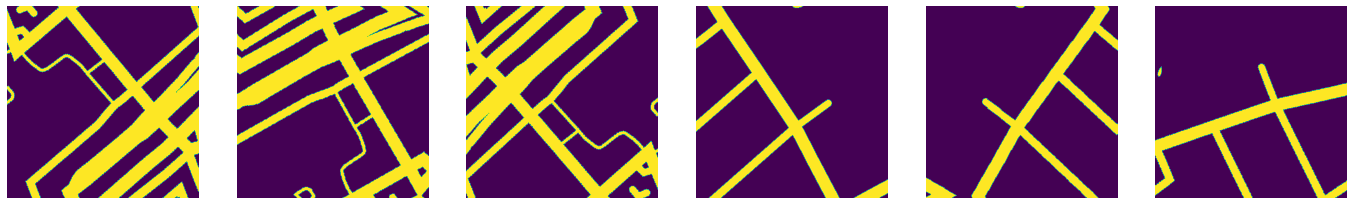

In [6]:
# after rotating by 0/90/180/270 degrees, the image will be 
# rotated by some random degree from the range [-ANGLE, ANGLE]
angle = 15

# how many new samples to generate from each original sample
n_samples_per_img = 3

transformed_imgs = []
transformed_masks = []

for (img, mask) in zip(images[:2], masks[:2]):
    for i in range(n_samples_per_img):
        img_size = img.size

        # reflection padding
        curr_img = TF.pad(img=img, 
                            padding=[img_size[0] // 5, img_size[1] // 5], 
                            padding_mode="reflect")
        curr_mask = TF.pad(img=mask, 
                            padding=[img_size[0] // 5, img_size[1] // 5], 
                            padding_mode="reflect")

        # rotation
        angle1 = random.choice([0, 90, 180, 270])
        angle2 = random.randint(-angle, angle)
        curr_img = TF.rotate(TF.rotate(curr_img, angle1), angle2)
        curr_mask = TF.rotate(TF.rotate(curr_mask, angle1), angle2)

        # flip
        if random.random() > 0.5:
            curr_img = TF.hflip(curr_img)
            curr_mask = TF.hflip(curr_mask)

        # center crop
        curr_img = TF.center_crop(curr_img, img_size)
        curr_mask = TF.center_crop(curr_mask, img_size)

        transformed_imgs.append(curr_img)
        transformed_masks.append(curr_mask)

plot_images(transformed_imgs)
plot_images(transformed_masks)

### Color jitters
Let us visualize some newly generated samples using our test images. Note that not all transformations will have an effect if image normalization is applied as a preprocessing step since simple shifts and stretches in each color channels will be cancelled by the normalization.

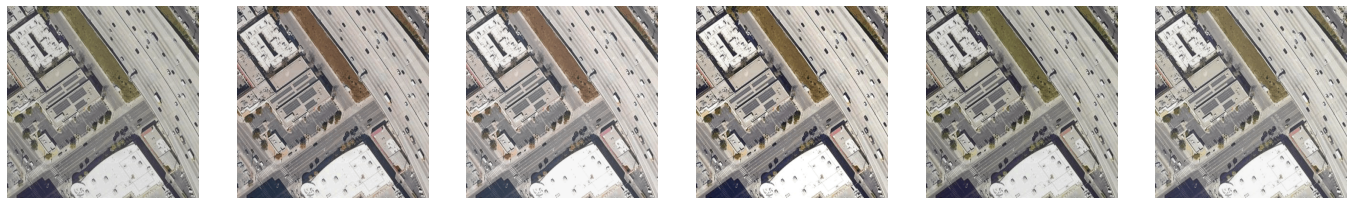

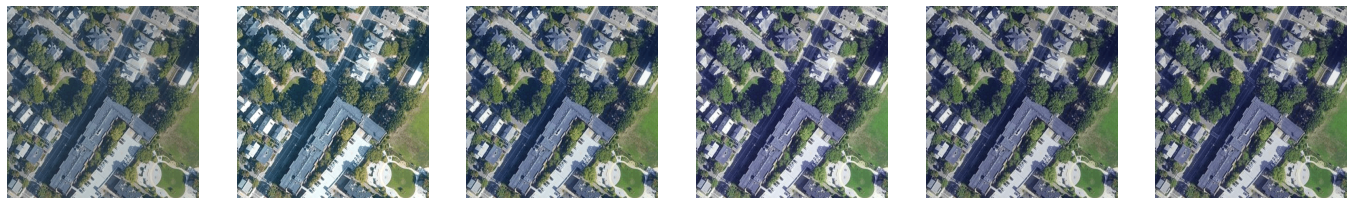

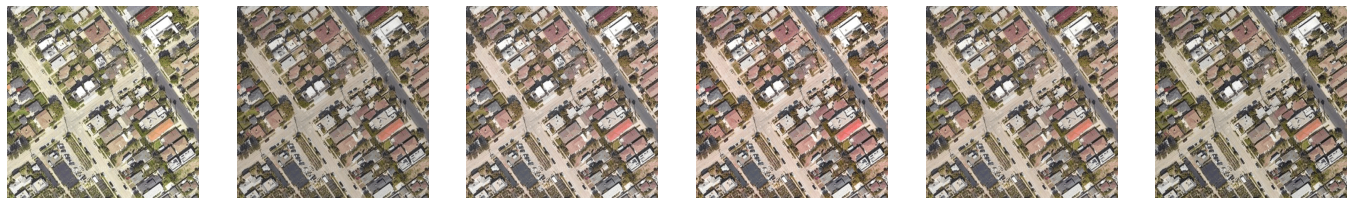

In [5]:
jitter = T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
n_samples_per_img = 6

for img in images:
    transformed_imgs = []

    for i in range(n_samples_per_img):
        transformed_imgs.append(jitter(img))

    plot_images(transformed_imgs)